# Impfquote im Kanton Zürich
Datum: 16.09.2021

Die Open-Data-Fachstelle des Kantons Zürich hat am 14.9.2021 neue Datensätze zur [#Covid19-Impfkampagne im Kanton Zürich](https://github.com/openZH/covid_19_vaccination_campaign_ZH) veröffentlicht und dies per [Tweet]( https://twitter.com/OpenDataZH/status/1437778195407941642) kommuniziert. 

In einem der Datensätze ist die Anzahl Impfungen pro Postleitzahl im Vergleich zur Bevölkerung enthalten. Ich habe mich gefragt, weshalb ich noch nie eine **Karte zum Anteil der geimpften pro PLZ im Kanton Zürich** gesehen habe. 
Deshalb spiele ich das hier mal durch und vermute, dass ich auf folgende Fragen stossen werde:

- Wie einfach ist die Datenaufbereitung der Geodaten der auf dem [Open-Data-Katalog der Post](https://swisspost.opendatasoft.com/pages/home/) verfügbaren [PLZ-Verzeichnis v2](https://swisspost.opendatasoft.com/explore/dataset/plz_verzeichnis_v2/information/?disjunctive.postleitzahl)?
- Bei Impfquoten scheint mir, dass in der Regel die Gesamtbevölkerung betrachtet wird. Wäre es nicht sinnvoller die Bevölkerung im 'impffähigen Alter' auszuweisen? Da Kinder bis 12 ja noch gar nicht geimpft werden können, sollte man diese für die Impfquote auch nicht berücksichtigen. Zumindest wenn man den 'Erfolg' der Impfkampagne messen möchte.

Nachtrag: Unterdessen sind alle Indikatoren und Daten interaktiv Visualisiert von Robert Salzer ([@robsalzer](https://twitter.com/rob_salzer)) auf seinem grossartigen Portal unter https://rsalzer.github.io/COVID_19_KT_ZH/

<!---  
Dieses Notebook verwendet als Vorlage die Webseite «[Kitas in Berlin - Jupyter Notebook](https://juanitorduz.github.io/kitas_berlin/)» 
---!>

Mit Colab kann **dieses Jupyter-Notebook interaktiv im Browser** gestartet werden:
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DonGoginho/myPy_RIS_API/blob/main/RIS_API_AL_Geschaefte.ipynb)



**Inhaltsverzeichnis:**

1. [Datenaufbereitung](#Datenaufbereitung)
2. [Daten prüfen](#)
3. [Daten analysieren](#Explorative_Analyse)



In [51]:
#%pip install geopandas fiona requests folium mplleaflet contextily

## Importiere notwendige Packages:

In [67]:
import numpy as np
import pandas as pd
import geopandas as gpd
import altair as alt
import fiona; 
import mplleaflet
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns




Optionale Settings

In [68]:
pd.options.display.float_format = '{:.0f}'.format
#pd.set_option('display.width', 100)
#pd.set_option('display.max_columns', 15)

In [69]:
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')

%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100

## Datenaufbereitung



### Datenquellen: ###

1. Geodaten [PLZ-Verzeichnis der Post](https://swisspost.opendatasoft.com/explore/dataset/plz_verzeichnis_v2/download/?format=shp&timezone=Europe/Berlin&lang=de) (shp, Geodaten)
2. Metadaten [PLZ-Verzeichnis v2](https://swisspost.opendatasoft.com/explore/dataset/plz_verzeichnis_v2/information/?disjunctive.postleitzahl)
3. Statistische Daten [Kumulierte Anzahl Impfungen nach Postleitzahl pro Kalenderwoche ab 18.01.2021](https://raw.githubusercontent.com/openZH/covid_19_vaccination_campaign_ZH/master/COVID19_Impfungen_pro_Woche_PLZ.csv) (csv, statistische Daten)
4. Detaillierte Doku (Metadaten) [Kumulierte Anzahl Impfungen nach Postleitzahl pro Kalenderwoche ab 18.01.2021](https://github.com/openZH/covid_19_vaccination_campaign_ZH) (Github)


### Datenaufbereitung des «PLZ Verzeichnis der Post (v2)» zu vierstelligen PLZ des Kantons Zürich

Die Geodaten aus dem **PLZ Verzeichnis** der Post entsprechen NICHT den vierstelligen Postleitzahlen (PLZ4), welche bei den statistischen Daten des Kantons Zürich und auch in aderen häufig verwendeten statistischen Daten verwendet werden. Sie sind umfangreicher und enthalten auch nicht territoriale PLZ. Daher müssen sie noch für die Verwendung aufbereitet werden. Leider sind die Metadaten zum PLZ Verzeichnis unvollständig. Daher beruht meine Datenaufbereitung auf einigen Annahmen und Erfahrungswerten.

Die Geodaten der Post können grundsätzlich entweder als [Shapefile oder GeoJSON-Datei heruntergeladen](https://swisspost.opendatasoft.com/explore/dataset/plz_verzeichnis_v2/export/?disjunctive.postleitzahl) oder per [API-request](https://swisspost.opendatasoft.com/explore/dataset/plz_verzeichnis_v2/api/) abgefragt werden.

Da die PLZ statische Objekte sind, die sich zeitlich nicht täglich ändern, verwende ich hier für die Datenaufbereitung die Option über den Datendownload via [Export](https://swisspost.opendatasoft.com/explore/dataset/plz_verzeichnis_v2/export/?disjunctive.postleitzahl) vom Datenkatalog herunter. Die Abfrage via API wäre natürlich effizienter, da wir bereits schon nur die für den Kanton Zürich relevanten PLZ herunter laden könnten.


#### Importiere die Shapefiles

Um mit Geodaten zu arbeiten, verwenden wir hier Geopandas.

`Alle Infos zu **Geopandas** findest Du hier https://geopandas.org/docs/user_guide/io.html`

Zum **ersten Datenbezug** können die Daten der POST als Shapefile herunter geladen werden. Für weitere Verwendungen wäre aber das lokale speichern natürlich von Vorteil. 

In [265]:
#[1] Direkter Shapefile-Import

url_shp = "https://swisspost.opendatasoft.com/explore/dataset/plz_verzeichnis_v2/download/?format=shp&timezone=Europe/Berlin&lang=de"
gdf_plz6_ch = gpd.read_file(url_shp)


print('done')

done


In [289]:
gdf_plz6_ch.head(3)

,rec_art,onrp,bfsnr,plz_typ,postleitzah,plz_zz,gplz,ortbez18,ortbez27,kanton,sprachcode,sprachcode_,briefz_durc,gilt_ab_dat,plz_briefzu,plz_coff,geometry
0,01,111,5586,80,1000,07,1000,Lausanne St-Paul,Lausanne St-Paul,VD,2,None,130,1993-09-28,100060,None,None
1,01,118,5586,80,1000,17,1000,Lausanne 17,Lausanne 17,VD,2,None,130,1986-05-21,100060,None,None
2,01,119,5586,80,1000,19,1000,Lausanne 19,Lausanne 19,VD,2,None,130,1993-09-28,100060,None,None


#### Selektiere PLZ des Kantons Zürich ####
Wähle aus allen PLZ der Schweiz nur jene, die im Kanton Zürich liegen.

In [301]:
gdf_plz6_ktzh = gdf_plz6_ch.query('kanton =="ZH"')
#gdf_plz6_ktzh = gdf_plz6_ch.query('kanton =="ZH" & plz_coff =="J"')
gdf_plz6_ktzh.head(2)
#gdf_plz6_ktzh.info()

,rec_art,onrp,bfsnr,plz_typ,postleitzah,plz_zz,gplz,ortbez18,ortbez27,kanton,sprachcode,sprachcode_,briefz_durc,gilt_ab_dat,plz_briefzu,plz_coff,geometry
1024,01,4387,261,20,8003,00,8000,Zürich,Zürich,ZH,1,None,10575,1990-01-01,803660,J,"POLYGON ((8.52294 47.36414, 8.52236 47.36383, ..."
1025,01,4388,261,20,8004,00,8000,Zürich,Zürich,ZH,1,None,9741,1990-01-01,801500,J,"POLYGON ((8.52823 47.36888, 8.52819 47.36886, ..."


### Selektiere die vierstelligen PLZ des Kantons Zürich ####
Uns interessieren die Geometrien/Grenzen der PLZ. Dazu muss man aber wissen, dass es auch **nicht-territoriale sechstellig PLZ** gibt. Soweit ich das verstanden habe, können diese mit plz_coff != 'J' herausgefiltert werden. So wie es aussieht existieren jene, die `plz_coff = 'None'` haben keine geografischen Grenzen, also auch keine Werte unter dem Attribut `geometry`. Offiziell heisst es bei der Post zur Bedeutung von plz_coff «Das Flag zeigt an, ob an der entsprechenden Domizil-PLZ ausschliesslich offizielle Gebäudeadressen enthalten sind.Die Information bezieht sich also nicht darauf, ob die PLZ offiziell oder nicht offiziell ist». Hier eine Auflistung **nicht-territorialer sechstelliger PLZ** im Kanton Zürich:



In [293]:
gdf_plz4_ktzh_nicht_territorial = gdf_plz6_ktzh.query('plz_coff !="J"')

gdf_plz4_ktzh_nicht_territorial.head()

,rec_art,onrp,bfsnr,plz_typ,postleitzah,plz_zz,gplz,ortbez18,ortbez27,kanton,sprachcode,sprachcode_,briefz_durc,gilt_ab_dat,plz_briefzu,plz_coff,geometry
1027,01,4396,247,80,8010,73,8010,Zürich Mülligen PL,Zürich Mülligen PL,ZH,1,None,6455,2013-05-01,801050,None,None
1028,01,4424,261,80,8021,00,8021,Zürich 1 Sihlpost,Zürich 1 Sihlpost,ZH,1,None,4425,2002-12-01,802102,None,None
1029,01,4425,261,30,8021,02,8000,Zürich 1,Zürich 1,ZH,1,None,4425,1998-03-05,802102,None,None
1030,01,4429,261,80,8023,00,8000,Zürich,Zürich,ZH,1,None,4425,1990-01-01,802102,None,None
1032,01,4444,261,80,8033,00,8000,Zürich,Zürich,ZH,1,None,7303,1990-01-01,805060,None,None


In [305]:
#Teste ob das bezüglich fehlender Geometrien stimmt:

#gdf_plz4_ktzh_nicht_territorial.isnull().sum()


Die uns interessierende **sechstelligen territorialen PLZ** filtern wir in diesem Falls mit `plz_coff == 'J'` heraus:

In [306]:
gdf_plz4_ktzh_sel = gdf_plz6_ktzh.query('plz_coff =="J"')
gdf_plz4_ktzh_sel.head(3)
#gdf_plz4_ktzh_sel.info()

,rec_art,onrp,bfsnr,plz_typ,postleitzah,plz_zz,gplz,ortbez18,ortbez27,kanton,sprachcode,sprachcode_,briefz_durc,gilt_ab_dat,plz_briefzu,plz_coff,geometry
1024,01,4387,261,20,8003,00,8000,Zürich,Zürich,ZH,1,None,10575,1990-01-01,803660,J,"POLYGON ((8.52294 47.36414, 8.52236 47.36383, ..."
1025,01,4388,261,20,8004,00,8000,Zürich,Zürich,ZH,1,None,9741,1990-01-01,801500,J,"POLYGON ((8.52823 47.36888, 8.52819 47.36886, ..."
1026,01,4391,261,20,8006,00,8000,Zürich,Zürich,ZH,1,None,7303,1990-01-01,805060,J,"POLYGON ((8.55064 47.37448, 8.55017 47.37439, ..."


Vierstellige PLZ sind eigentlich nur in Kombination mit der Ortsbezeichnung, also z.B. **8044-Zürich** oder **8044-Gockhausen** / **8105-Regensdorf** oder **8105-Watt**, eindeutig. Die statistischen Daten des Kantons kommen aber nur via vierstelliger PLZ. Daher müssen die Grenzen der beiden Gebiete noch zusammengelegt werden. 

In [307]:
gdf_plz4_ktzh_sel = gdf_plz6_ktzh.query('plz_coff =="J"& (postleitzah == "8044" | postleitzah == "8105")')
gdf_plz4_ktzh_sel.head(2)
#gdf_plz4_ktzh_sel.info()

,rec_art,onrp,bfsnr,plz_typ,postleitzah,plz_zz,gplz,ortbez18,ortbez27,kanton,sprachcode,sprachcode_,briefz_durc,gilt_ab_dat,plz_briefzu,plz_coff,geometry
2833,01,4457,261,10,8044,00,8000,Zürich,Zürich,ZH,1,None,4443,1990-01-01,803260,J,"POLYGON ((8.60188 47.37176, 8.60167 47.37178, ..."
2839,01,4497,96,10,8105,00,8105,Regensdorf,Regensdorf,ZH,1,None,8324,1987-10-01,810760,J,"POLYGON ((8.46245 47.41885, 8.46211 47.41883, ..."


Hier die zwei Beispiele von oben gemapped:

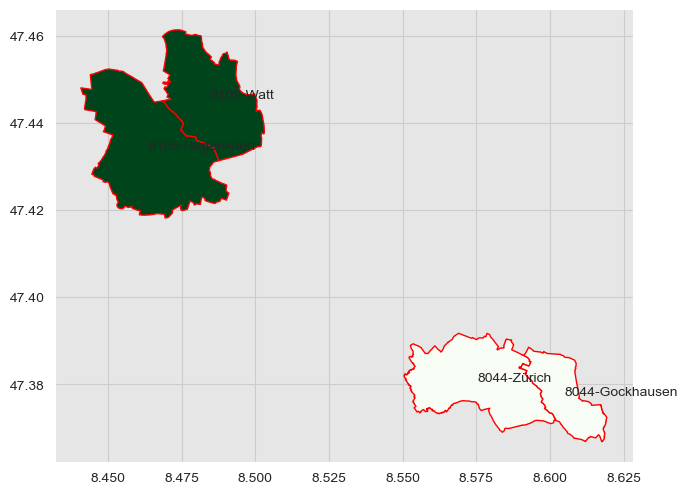

In [308]:
ax = gdf_plz4_ktzh_sel.plot(column='gplz', cmap='Greens', edgecolor='red')

gdf_plz4_ktzh_sel.apply(lambda x: ax.annotate(text=x.postleitzah + "-"+x.ortbez18 , xy=x.geometry.centroid.coords[0], ha='left'), axis=1);


#### Geometrische Vereinigung (dissolve) von Dubletten bei vierstelligen ####
Wenn man die aufbereiteten Daten auf Doubletten überprüft, so sieht man, dass es noch einige PLZ4 gibt, die eigentlich - basierend auf dem Attribut `postleitzah` - zusammen gehören, aber zwei geometrische Objekte darstellen, da sie wie oben erwähnt nur in Kombination mit dem Namen eindeutig sind. Deshalb identifizieren wir hier zuerst einmal die Doubletten der `postleitzah`und vereinigen in einem zweiten Schritt diese Objekte zu einem geometrischen Objekt.

1. **Wo kommen PLZ4 doppelt vor?** (checke mit `duplicated` und zeige die ersten Doppelten Objekte an)



Duplicate Rows except first occurrence based on 'postleitzah' columns are :


<AxesSubplot:>

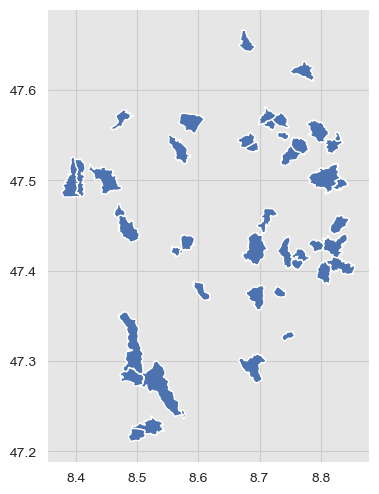

In [102]:
# Select duplicate rows except first occurrence based the variable `postleitzah'
duplicateRowsDF = gdf_plz4_ktzh_sel[gdf_plz4_ktzh_sel.postleitzah.duplicated(keep="first")]
print("Duplicate Rows except first occurrence based on 'postleitzah' columns are :")
#print(duplicateRowsDF)
duplicateRowsDF.plot()

2. **Vereinigung der Doubletten**

Dazu verwenden wir die GIS-Methode [**`dissolve`**](https://geopandas.org/docs/reference/api/geopandas.GeoDataFrame.dissolve.html?highlight=dissolve).

<AxesSubplot:>

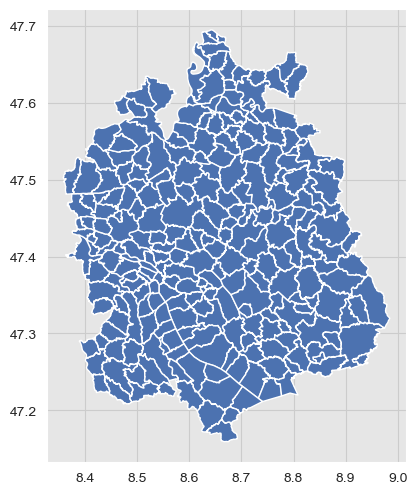

In [103]:
gdf_plz4_ktzh_dissolved = gdf_plz4_ktzh_sel.dissolve(by='postleitzah', aggfunc='first', as_index=False, level=None, sort=True, observed=False, dropna=True)

gdf_plz4_ktzh_dissolved.plot()

#Check on duplicates again:
#duplicateRowsDF = gdf_plz4_ktzh_dissolved[gdf_plz4_ktzh_dissolved.postleitzah.duplicated(keep="first")]
#print(duplicateRowsDF)


In [104]:
#gdf_plz4_ktzh_dissolved.info()

#### PLZ4-Gebiete des Kantons ZH fertig stellen ####

Damit haben wir die PLZ-Geodaten, wie wir sie für die weiteren Schritte benötigen. Daher benenne ich den GeoDataFrame als `gdf_plz4_ktzh`



In [105]:
gdf_plz4_ktzh = gdf_plz4_ktzh_dissolved


Zur weiteren Bearbeitung in anderen Tools kann ich sie auch als Geodaten abspeichern.
Hier z.B. als GeoJSON-File und als GeoPackage

In [106]:
gdf_plz4_ktzh.to_file("./output/plz4_ktzh.geojson", driver='GeoJSON')

gdf_plz4_ktzh.to_file("./output/plz4_ktzh.gpkg", layer='plz4_ktzh', driver="GPKG")

Wenn auf die komplette Datenaufbereitung - wie hier beschrieben - verzichtet werden kann, weil die Daten erst entsprechend aufbereitet wurden, so können sie folgendermassen für die weiteren Schritte importiert werden.

In [309]:
#path2gpkg ="./output/plz4_ktzh.gpkg"
#gdf_plz4_ktzh_imp = gpd.read_file(path2gpkg, layer='plz4_ktzh')
#gdf_plz4_ktzh_imp.info()

### Statistische Daten der COVID19-Impfkampagne einlesen


Die statistischen #OpenData Daten [Kumulierte Anzahl Impfungen nach Postleitzahl pro Kalenderwoche ab 18.01.2021](https://raw.githubusercontent.com/openZH/covid_19_vaccination_campaign_ZH/master/COVID19_Impfungen_pro_Woche_PLZ.csv) (csv, statistische Daten) sollen eingelesen und die aktuellsten Zahlen den PLZ4 zugeordnet werden. Hier gibt es noch eine ausführliche [Doku (Metadaten)](https://github.com/openZH/covid_19_vaccination_campaign_ZH) (Github) zum Datensatz.



In [27]:
# Filepath
fp = r"https://raw.githubusercontent.com/openZH/covid_19_vaccination_campaign_ZH/master/COVID19_Impfungen_pro_Woche_PLZ.csv"

# Read the data
pd_covid19_impf_woche_plz4 = pd.read_csv(
    fp, 
    sep=',',
    parse_dates=True,
    low_memory=False    
    )
pd_covid19_impf_woche_plz4.head(20000)

,week_from,week_until,calendar_week,plz,population,ncumul_firstvacc,ncumul_secondvacc
0,2021-01-01,2021-01-24,3,8001,5473,136,0
1,2021-01-01,2021-01-24,3,8002,9620,188,0
2,2021-01-01,2021-01-24,3,8003,20655,275,0
3,2021-01-01,2021-01-24,3,8004,27183,289,0
4,2021-01-01,2021-01-24,3,8005,15505,165,0
...,...,...,...,...,...,...,...
8631,2021-09-06,2021-09-12,36,8955,2505,1583,1394
8632,2021-09-06,2021-09-12,36,andere Kantone,NaN,7789,6905
8633,2021-09-06,2021-09-12,36,Nachbarkantone,NaN,28411,25018
8634,2021-09-06,2021-09-12,36,unbekannt,NaN,7728,6756


In [28]:
#pd_covid19_impf_woche_plz4.dtypes

#### Selektion und Berechnungen ####
Welche Kalenderwoche soll ausgewählt werden?
Hier bestimme ich mal die aktuellste Kalenderwoche.

In [29]:
latest_week = pd_covid19_impf_woche_plz4.calendar_week.max()
print(latest_week)


36


In [30]:
sel_covid19_impf_woche_plz4_development = (
    pd_covid19_impf_woche_plz4.query("calendar_week > @latest_week-12")
    .assign(
        prcFirstVac=lambda x: 100-(x.population - x.ncumul_firstvacc)/x.population*100 ,
        prcSecVac=lambda x: 100-(x.population - x.ncumul_secondvacc)/x.population*100,
    )
    .sort_values('prcSecVac', ascending=True)
    #.head(200)
)
sel_covid19_impf_woche_plz4 = pd_covid19_impf_woche_plz4.query("calendar_week > @latest_week-1")

In [31]:
alt.Chart(sel_covid19_impf_woche_plz4_development).mark_circle(size=60).encode(
    x='plz', #QuarLang
    y='prcSecVac',
    color=alt.Color('calendar_week', scale=alt.Scale(scheme='blues')),
    tooltip=['plz','prcSecVac','week_from']
).interactive() # this makes the axes interactive: now you can zoom & pan



alt.Chart(...)

In [32]:
#sel_covid19_impf_woche_plz4.plot(kind="scatter", x="plz", y="prcSecVac")


### Importiere Städtische Daten
Importiere zum Test Daten von Statistik Stadt Zürich von **Anzahl Personen nach impffähigen Alter** in der Stadt Zürich, Stand 31.12.2020.

In [34]:
# Filepath
fp = r"./ssz_plz4_impffaehiges_alter/wbev_plz_impffaehiges-alter_aktJahresbest.csv"


# Read the data
ssz_wbev_alter= pd.read_csv(
    fp, 
    sep=',',
    parse_dates=True,
    low_memory=False    
    )
ssz_wbev_alter.head(2)

,Beob.,StichtagDatJahr,PLZ,impffaehiges_alter,AnzBestWir,AnzBest
0,1,2020,8001,impffaehig,5453,6206
1,2,2020,8001,unter13,391,399


Erstelle einen DataFrame mit der Anzahl Personen pro PLZ total. Unabhänig vom Alter.

In [35]:
#ssz_wbev_impffaehiges_alter.head(2)

ssz_total_wbev_plz=ssz_wbev_alter[["PLZ", "AnzBestWir"]].groupby(['PLZ']).sum()



In [36]:
ssz_total_wbev_plz = ssz_total_wbev_plz.rename(columns={"AnzBestWir": "stzh_TotalWBev"})

In [37]:
ssz_total_wbev_plz.head(2)


,stzh_TotalWBev
PLZ,
8001,5844
8002,9820


Erstlle ein DF mit den Personen im impffähigen Alter. Lösche dabei noch die Personen in PLZ, die mehrheitlich ausserhalb der Stadtgebiets liegen (PLZ >8099). Dies liegt daran, dass die Gemeindegrenzen und die PLZ-Grenzen überlappend sind.

In [38]:
ssz_wbev_impffaehiges_alter = (
    ssz_wbev_alter.query("impffaehiges_alter == 'impffaehig' & PLZ<8100 & AnzBestWir>3")
    .assign(
        #AnzUeber13J=lambda x: impffaehiges_alter == 'impffaehig',
    )
    .sort_values('PLZ', ascending=True)
)

In [39]:
#ssz_wbev_impffaehiges_alter

#### Joine die Daten
Damit die `PLZ` aus den Daten der Stadt Zürich mit den `plz` des Kantons gejoint werden können, müssen sie gleich heissen UND vom gleichen Typ sein. 
Hier wird eine neue Variable als String erstellt.

In [40]:
ssz_wbev_impffaehiges_alter['plz'] = ssz_wbev_impffaehiges_alter['PLZ'].astype(str)
ssz_wbev_impffaehiges_alter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24 entries, 0 to 48
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Beob.               24 non-null     int64 
 1   StichtagDatJahr     24 non-null     int64 
 2   PLZ                 24 non-null     int64 
 3   impffaehiges_alter  24 non-null     object
 4   AnzBestWir          24 non-null     int64 
 5   AnzBest             24 non-null     int64 
 6   plz                 24 non-null     object
dtypes: int64(5), object(2)
memory usage: 1.5+ KB


Als nächster Schritt wähle ich nur die relevanten Attribute aus und benenne diese wo sinnvoll um. Hier bedeutet `AnzPersUe12`die Anzahl Personen der wirtschaftlichen Wohnbevölkerung der Stadt Zürich, die über 12 Jahre alt ist.

In [41]:
ssz_wbev_impffaehiges_alter2join = ssz_wbev_impffaehiges_alter[["plz","PLZ","AnzBestWir"]]
ssz_wbev_impffaehiges_alter2join = ssz_wbev_impffaehiges_alter2join.rename(columns={"AnzBestWir": "stzh_AnzPersUe12"})
#ssz_wbev_impffaehiges_alter2join.info()

Und das gleiche noch mit den Kantonalen Daten:

In [42]:
sel_covid19_impf_woche_plz42join = sel_covid19_impf_woche_plz4[["calendar_week","plz","population","ncumul_firstvacc","ncumul_secondvacc"]]
#sel_covid19_impf_woche_plz42join = sel_covid19_impf_woche_plz4[["plz","population","ncumul_firstvacc","ncumul_secondvacc","prcFirstVac","prcSecVac","calendar_week"]]
sel_covid19_impf_woche_plz42join =sel_covid19_impf_woche_plz42join.rename(columns={"population": "ktzh_AnzPersTotal", "ncumul_firstvacc": "ktzh_ncumul_firstvacc", "ncumul_secondvacc": "ktzh_ncumul_secondvacc"})
sel_covid19_impf_woche_plz42join.head(2)

,calendar_week,plz,ktzh_AnzPersTotal,ktzh_ncumul_firstvacc,ktzh_ncumul_secondvacc
8382,36,8001,5473,4328,3798
8383,36,8002,9620,6883,6259


In [43]:
#sel_covid19_impf_woche_plz4.info()

Nun joine, resp. merge, ich die Daten der Stadt Zürich mit den Angaben des Kantons Zürich zusammen.
In der Stadt wird die numerische `PLZ`, beim Kanton der string `plz` verwendet.

In [44]:
join_ssz_a = ssz_wbev_impffaehiges_alter2join.merge(ssz_total_wbev_plz, on=["PLZ"])

join_ssz_kt = join_ssz_a.merge(sel_covid19_impf_woche_plz42join, on=["plz"])
#country_shapes = country_shapes.merge(country_names, on='iso_a3')

join_ssz_kt.head(2)

,plz,PLZ,stzh_AnzPersUe12,stzh_TotalWBev,calendar_week,ktzh_AnzPersTotal,ktzh_ncumul_firstvacc,ktzh_ncumul_secondvacc
0,8001,8001,5453,5844,36,5473,4328,3798
1,8002,8002,8437,9820,36,9620,6883,6259


In [46]:
compare_ssz_kt = (
    join_ssz_kt.query(" stzh_AnzPersUe12 > 0")
    .assign(
        prc_ktzh_1Vac=lambda x: 100-(x.ktzh_AnzPersTotal - x.ktzh_ncumul_firstvacc)/x.ktzh_AnzPersTotal*100 ,
        prc_ktzh_2Vac=lambda x: 100-(x.ktzh_AnzPersTotal - x.ktzh_ncumul_secondvacc)/x.ktzh_AnzPersTotal*100,
        prc_stzh_1Vac=lambda x: 100-(x.stzh_AnzPersUe12 - x.ktzh_ncumul_firstvacc)/x.stzh_AnzPersUe12*100 ,
        prc_stzh_2Vac=lambda x: 100-(x.stzh_AnzPersUe12 - x.ktzh_ncumul_secondvacc)/x.stzh_AnzPersUe12*100,
        diff_prc_stzh_ktzh_2Vac=lambda x: x.prc_stzh_2Vac - x.prc_ktzh_2Vac ,
        diff_totalPop_stzh_ktzh=lambda x: x.stzh_TotalWBev - x.ktzh_AnzPersTotal ,

    )
    .sort_values('diff_totalPop_stzh_ktzh', ascending=False)
    
)

In [47]:
compare_ssz_kt.head(50)

,plz,PLZ,stzh_AnzPersUe12,stzh_TotalWBev,calendar_week,ktzh_AnzPersTotal,ktzh_ncumul_firstvacc,ktzh_ncumul_secondvacc,prc_ktzh_1Vac,prc_ktzh_2Vac,prc_stzh_1Vac,prc_stzh_2Vac,diff_prc_stzh_ktzh_2Vac,diff_totalPop_stzh_ktzh
22,8057,8057,19925,23045,36,21221,14958,13546,70,64,75,68,4,1824
17,8050,8050,26390,30556,36,28957,19348,17498,67,60,73,66,6,1599
5,8006,8006,17108,19379,36,18387,13790,12726,75,69,81,74,5,992
6,8008,8008,15720,17545,36,16571,12606,11530,76,70,80,73,4,974
3,8004,8004,25881,28113,36,27183,19228,16992,71,63,74,66,3,930
16,8049,8049,21023,24405,36,23561,16341,15023,69,64,78,71,8,844
13,8046,8046,22285,26420,36,25704,14922,13281,58,52,67,60,8,716
8,8037,8037,14705,16634,36,16044,11440,10381,71,65,78,71,6,590
19,8052,8052,17838,20863,36,20277,11689,10323,58,51,66,58,7,586
18,8051,8051,20380,23550,36,23000,12979,11510,56,50,64,56,6,550


Woher rühren die Unterschiede zwischen der Totalbevölkerung der Stadt Zürich pro PLZ je nach Datenquelle?

In [421]:
#test=gdf_plz4_ktzh.query('postleitzah == "8125" | postleitzah == "8134" | postleitzah == "8142" | postleitzah == "8143" | postleitzah == "8152"')
#test.plot()

In [46]:
# Read abt. Geopandas https://geopandas.org/docs/user_guide/io.html

## Explorative_Analyse
One of the main objectives of this notebook is to do an exploratory data analysis to understand which questions this data set can answer. In addition, also determine its limitations. 

To begin, let us get the number of unique values per feature.


In [49]:
compare_ssz_kt.apply(lambda x: x.unique().size, axis=0)


plz                        24
PLZ                        24
stzh_AnzPersUe12           24
stzh_TotalWBev             24
calendar_week               1
ktzh_AnzPersTotal          24
ktzh_ncumul_firstvacc      24
ktzh_ncumul_secondvacc     24
prc_ktzh_1Vac              24
prc_ktzh_2Vac              24
prc_stzh_1Vac              24
prc_stzh_2Vac              24
diff_prc_stzh_ktzh_2Vac    24
diff_totalPop_stzh_ktzh    24
dtype: int64

Vorlage Code zur Aggregation

In [50]:
 #   .query('kategorie == "Parkbaum"') \
#    .agg(anz_baeume=('objid', 'count'), anz_kinder_va_sk=('objid', 'sum')) \
df_briefkaesten_zuerich \
    .groupby(['address_zip' ]) \
    .agg(anz_briefkaesten=('Id', 'count')) \
    .sort_values('anz_briefkaesten', ascending=False) \
    .head(5)
